# Numerical Variable Analysis

In [2]:
#pip install plotly

In [3]:
import pandas as pd
import plotly.express as ex
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
%%timeit
df = pd.read_excel("Cleansing the data/result clean data.xlsx")

14.3 s ± 213 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
df[df.columns].dtypes.value_counts()

float64           26
object            19
int64              6
datetime64[ns]     1
dtype: int64

In [6]:
non_category_columns = [x for x in df.columns if df[x].dtypes != 'O']
non_category_columns.remove('Au date')

date_column = [x for x in df.columns if df[x].dtypes == "datetime64[ns]"] 

columns_to_remove = [x for x in non_category_columns if df[x].value_counts().count() < 8]
columns_to_remove.remove('15_Daily_Output')
columns_to_remove.remove('15__TPR_20,10')
columns_to_remove.append('Audit_ID')
columns_to_remove.append('Case:')

numerical_columns = [x for x in non_category_columns if x not in columns_to_remove]
numerical_columns

['6_k_user',
 '10_k_user',
 '15_k_user',
 '18_k_user',
 '6FFF_k_user',
 '10FFF_k_user',
 '6_Daily_Output',
 '10_Daily_Output',
 '15_Daily_Output',
 '18_Daily_Output',
 '6FFF_Daily_Output',
 '10FFF_Daily_Output',
 '6__TPR_20,10',
 '10__TPR_20,10',
 '15__TPR_20,10',
 '18__TPR_20,10',
 '6FFF__TPR_20,10',
 '10FFF__TPR_20,10',
 'num_metric',
 'predictedValue']

## Missing values in each column

In [7]:
missing_count = df[numerical_columns].isna().sum()
missing_count = missing_count.sort_values(ascending = False)

missing_percent = (df[numerical_columns].isna().sum() / df[numerical_columns].shape[0]) * 100
missing_percent = missing_percent.sort_values(ascending = False)

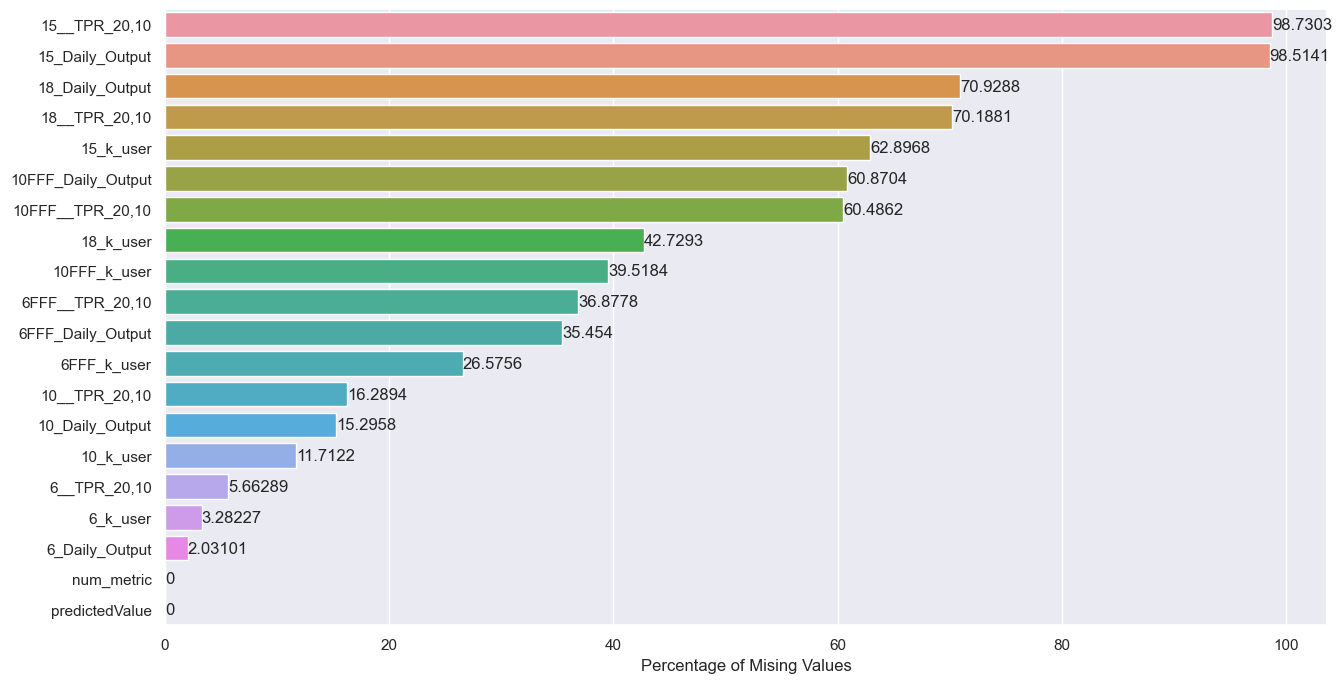

In [8]:
sns.set(rc={'figure.figsize':(15,8)})

ax = sns.barplot(y = missing_percent.index, x = missing_percent.values, orient='h')
ax.set(xlabel="Percentage of Mising Values", yticklabels=missing_percent.index)
sns.set_theme(style = "white")
for i in ax.containers:
    ax.bar_label(i,)

In [9]:
number_of_columns = len(numerical_columns)
number_of_columns

20

In [20]:
print(f"Total number of features to be included in the numerical analysis: {len(numerical_columns)}")
for col in df[numerical_columns].columns:
    print(col)

Total number of features to be included in the numerical analysis: 20
6_k_user
10_k_user
15_k_user
18_k_user
6FFF_k_user
10FFF_k_user
6_Daily_Output
10_Daily_Output
15_Daily_Output
18_Daily_Output
6FFF_Daily_Output
10FFF_Daily_Output
6__TPR_20,10
10__TPR_20,10
15__TPR_20,10
18__TPR_20,10
6FFF__TPR_20,10
10FFF__TPR_20,10
num_metric
predictedValue


## Distributions of each feature

In [11]:
df['predictedValue'].min()

-0.4290067085475666

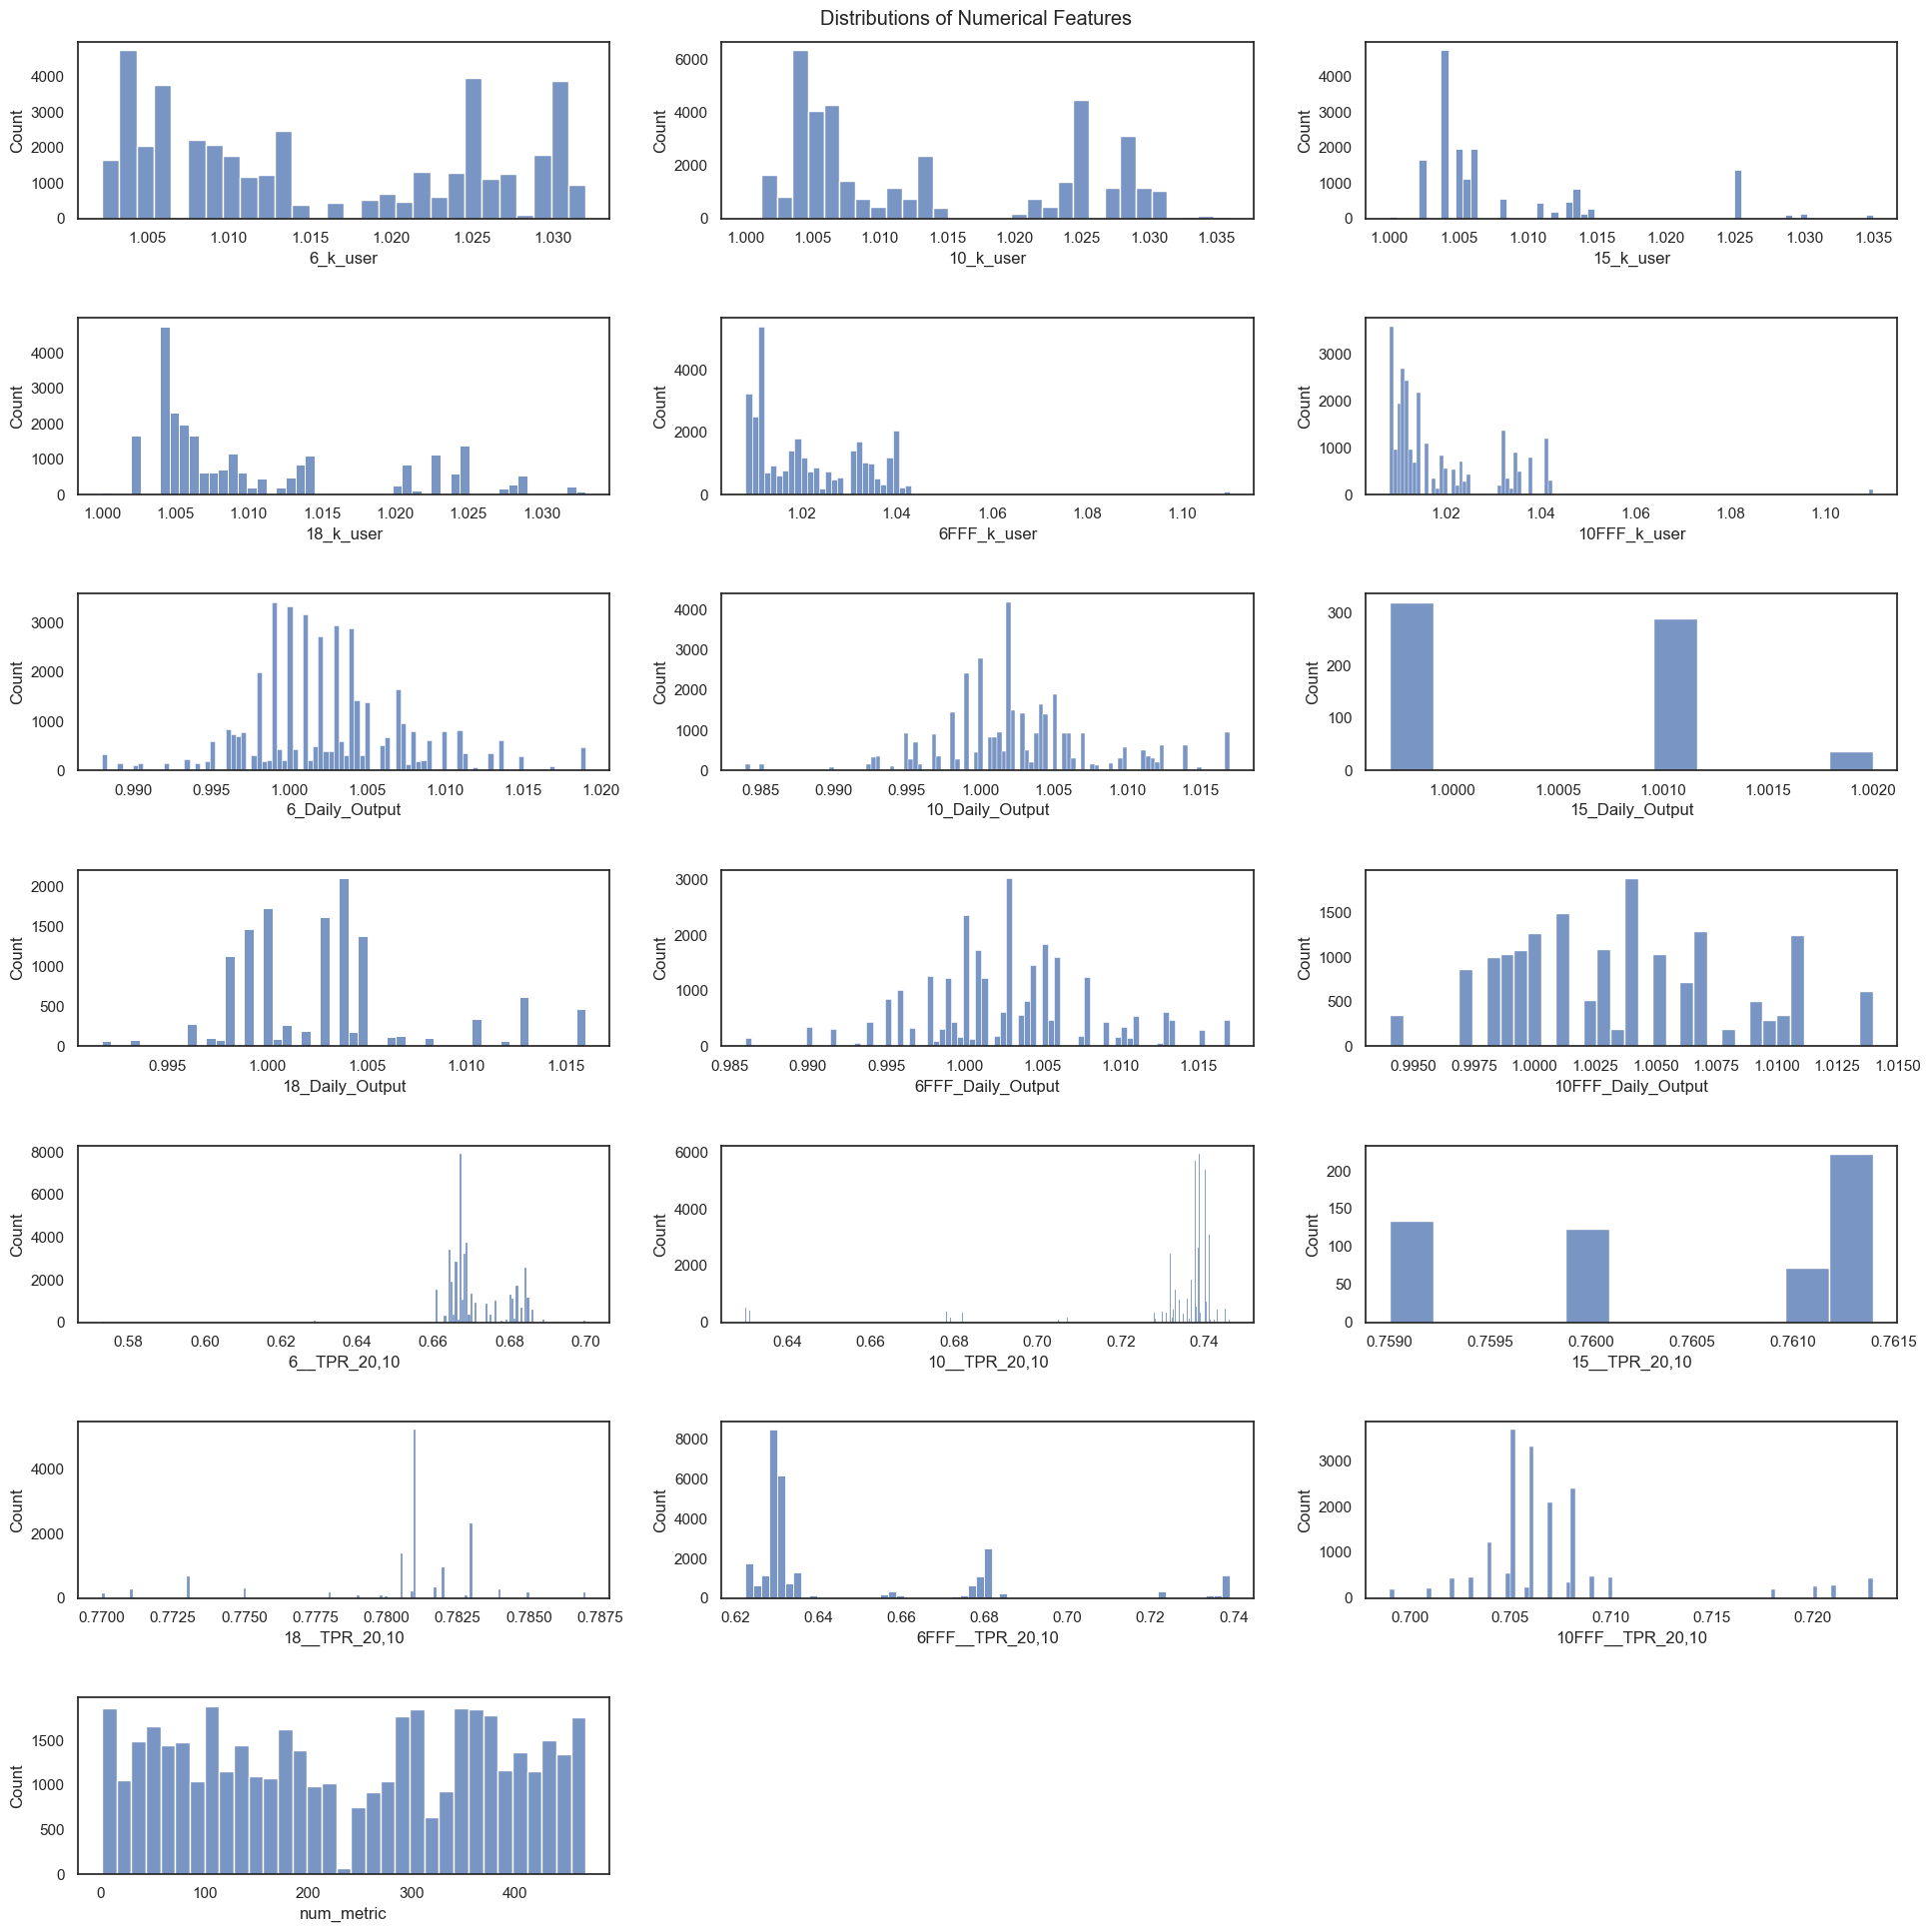

In [12]:
rows = 7
cols = 3
fig, ax = plt.subplots(ncols = cols, nrows=rows, squeeze= False, figsize = (20,20))
fig.tight_layout(pad=4)
for i in range(len(numerical_columns)-1):
    row = i//cols
    col = i%cols
    sns.histplot(df[numerical_columns[i]], ax = ax[row, col])
    
fig.suptitle("Distributions of Numerical Features")
    
ax[6,2].set_axis_off()
ax[6,1].set_axis_off()

## Ranges and Potential Outliers

[]

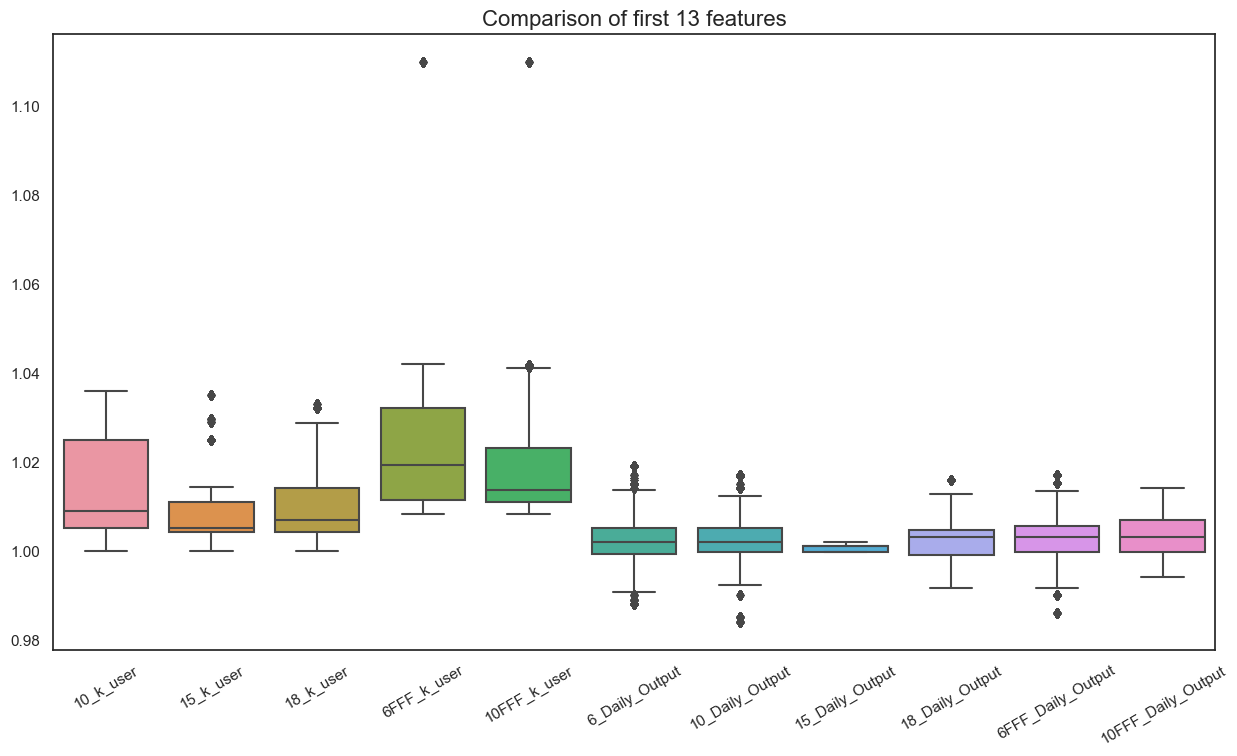

In [13]:
box = sns.boxplot(df[numerical_columns].iloc[:,1:12])
box.set_xticklabels(numerical_columns[1:12], rotation = 30)

plt.title("Comparison of first 13 features", fontsize = 16)
# plt.xticks(fontsize = 10)

box.plot()

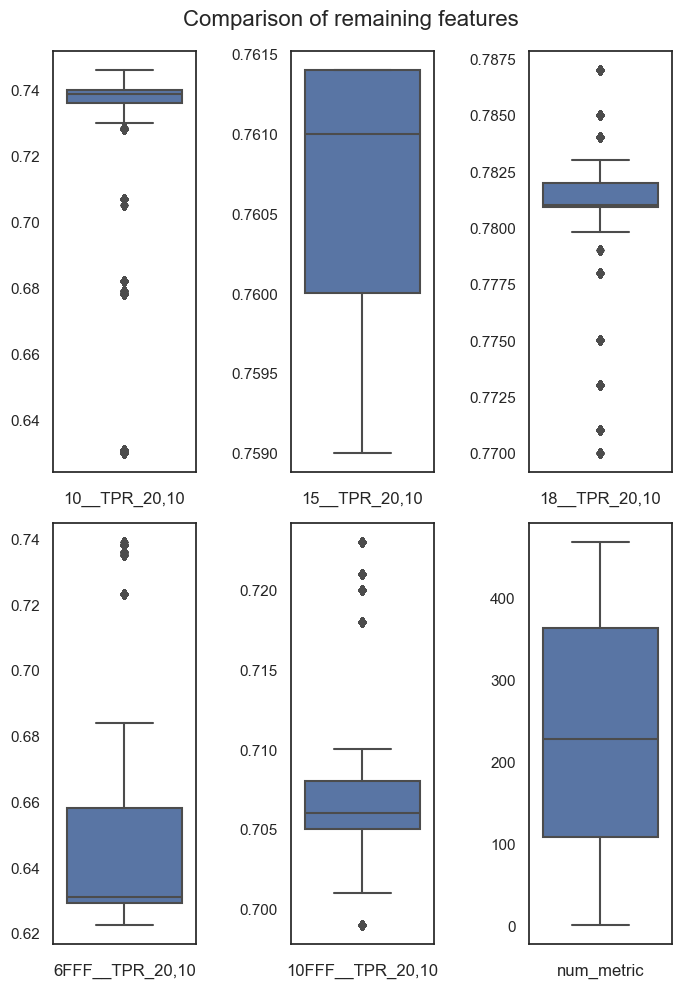

In [14]:
# plt.xticks(fontsize = 10)

box.plot()

fig, ax = plt.subplots(nrows=2, ncols=3, squeeze= True, figsize = (7,10))
fig.suptitle("Comparison of remaining features", fontsize = 16)
fig.tight_layout(w_pad=3)

for i in range(len(numerical_columns[13:-1])):
    row = i//3
    column = i%3
    p = sns.boxplot(df[numerical_columns[13+i]], ax = ax[row,column])
    p.set(xlabel=numerical_columns[13+i])
    p.set(xticklabels="")
    
# ax[2,2].set_axis_off()
# ax[2,1].set_axis_off()

## Plotting number of audits over time

Text(0.5, 1.0, 'Number of Audits over time')

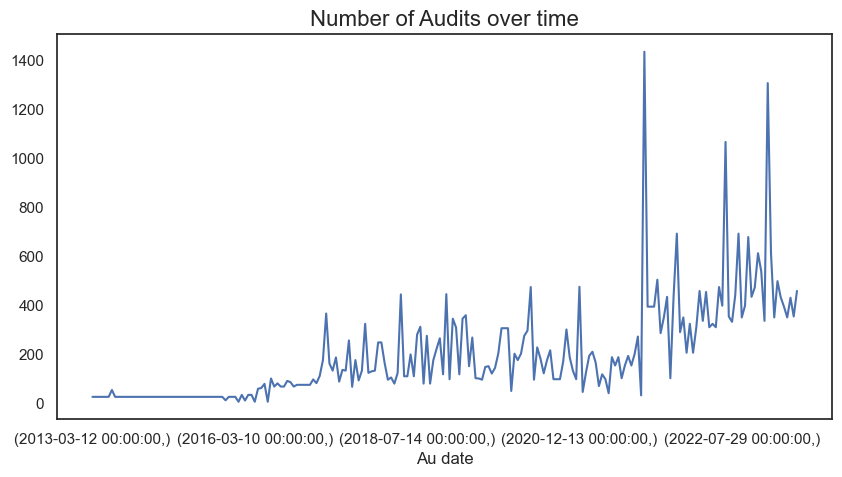

In [15]:
dates = df[date_column].value_counts().sort_index()
dates.plot(figsize = (10,5))
plt.title("Number of Audits over time", fontsize = 16)

## Heatmap of numerical data

In [16]:
df["predictedValue"]

0          -0.011864
1          -0.008924
2          -0.013807
3          -0.011913
4          -0.013800
            ...     
43471    1206.000000
43472     960.000000
43473     700.000000
43474    1014.000000
43475    1303.000000
Name: predictedValue, Length: 43476, dtype: float64

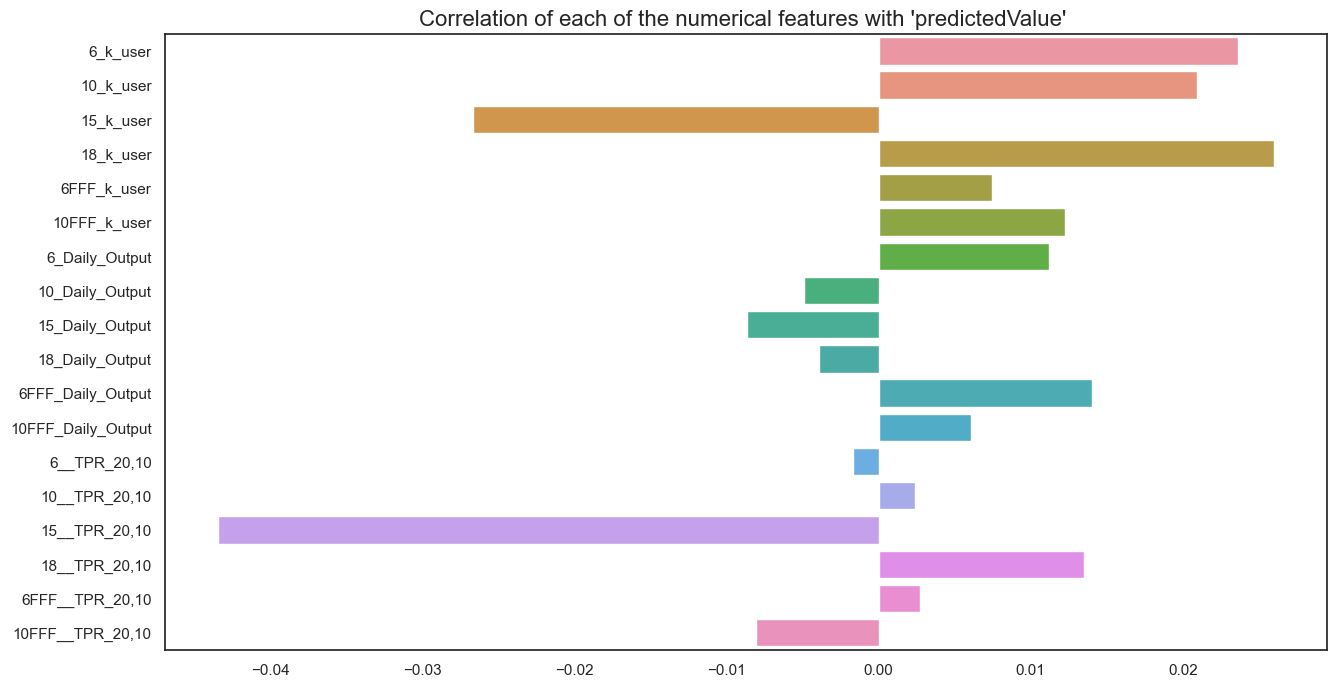

In [17]:
corr_data = df[numerical_columns[:-2]].corrwith(df["predictedValue"])
sns.barplot(y = corr_data.index,  x = corr_data.values, orient='h')

plt.title("Correlation of each of the numerical features with 'predictedValue' ", fontsize = 16)
plt.show()

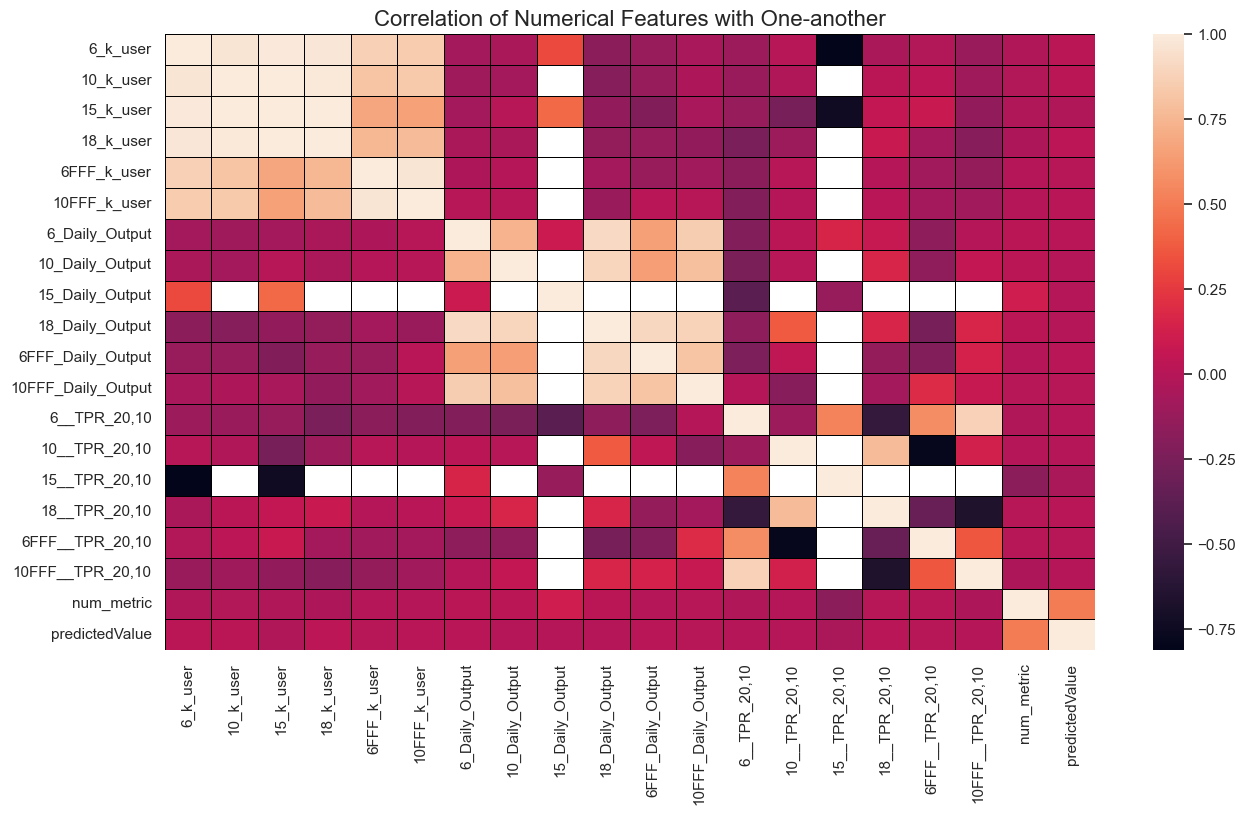

In [18]:
sns.heatmap(df[numerical_columns].corr(),linewidths=0.5, linecolor='black')
plt.title("Correlation of Numerical Features with One-another", size = 16)
plt.show()